In [1]:
# always import
import sys
import time
import os

# numpy & scipy
import numpy as np
import scipy

# sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import pairwise_distances_argmin, pairwise_distances
from sklearn import neighbors
from sklearn import cluster

# Hungarian algorithm
# from munkres import Munkres
from scipy.optimize import linear_sum_assignment

# visuals
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.manifold import Isomap, TSNE
import seaborn as sns
import pandas as pd

# maybe
from numba import jit

In [2]:
# load MNIST data and normalization
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='mnist/')
y = np.asarray(list(map(int, y)))
X = np.asarray(X.astype(float))
X = scale(X)
n_digits = len(np.unique(y))

In [3]:
## dimensionality reduction
np.random.seed(0)
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

In [4]:

def sample_wo_replacement(n, K, seed):
    np.random.seed(seed)
    indices = np.random.choice([i for i in range(n)], K, replace=False)
    return indices


def dimen_redn_pca(data, d):
    pca = PCA(n_components=d)
    data_proj = pca.fit_transform(data)
    return data_proj


def print_clustering_metrics(labels_true, labels_pred):
    homogeneity_score = metrics.homogeneity_score(labels_true, labels_pred)
    completeness_score = metrics.completeness_score(labels_true, labels_pred)
    v_measure_score = metrics.v_measure_score(labels_true, labels_pred)
    rand_score = metrics.adjusted_rand_score(labels_true, labels_pred)
    mi_score = metrics.adjusted_mutual_info_score(labels_true, labels_pred)
    
    print(f"Clustering Metrics")
    print(f"-------------------------------------")
    print(f"Homogeneity score: {homogeneity_score}")
    print(f"Completeness score: {completeness_score}")
    print(f"V measure score: {v_measure_score}")
    print(f"Adjusted rand score: {rand_score}")
    print(f"Adjusted mutual information score: {mi_score}")


def cost_matrix(n, labels_true, labels_pred):
    K = np.unique(labels_pred)
    W = np.zeros((len(K), len(K)))
    
    for i in range(len(K)):
        pred_i = set([k for k in range(n) if labels_pred[k]==i])
        for j in range(len(K)):
            true_j = set([k for k in range(n) if labels_true[k]==j])
            W[i,j] = 1 - (len(pred_i & true_j))
    for i in range(len(K)):
        min_row = np.min(W[i,:])
        W[i,:] -= min_row
        
    return W

In [27]:
# TODO: Kmeans

class KMeans():
    def __init__(self, K, threshold, iters):
        self.K = K
        self.threshold = threshold
        self.iters = iters
        
    def fit(self, data, initialization_method, seed=None):
        
        if initialization_method=='pca':
            # get top-K principle eigenvectors from data (X)
            np.random.seed(0)
            pca = PCA()
            pca.fit(data)
            cluster_centroids = pca.components_[:self.K]
            
        elif initialization_method=='random':
            indices = sample_wo_replacement(len(data), self.K, seed)
            cluster_centroids = data[indices, :]
        
        prev_sse = np.inf
        
        for i in range(self.iters):
            cluster_members = dict()
            for j in range(self.K):
                cluster_members[j] = []
            
            # one pass through entire dataset
            for j in range(len(data)):
                dists_to_centroid = [np.linalg.norm(cluster_centroids[k]-data[j]) for k in range(self.K)]
                cluster_rep = dists_to_centroid.index(np.min(dists_to_centroid))
                cluster_members[cluster_rep].append(j)
            
            # assign cluster based label to each data point
            cluster_labels = [0 for j in range(len(data))]
            for key in cluster_members.keys():
                for j in cluster_members[key]:
                    cluster_labels[j] = key
            
            for k in range(self.K):
                cluster_centroids[k] = np.mean(data[cluster_members[k],:], axis=0)
                
            dists = [(np.linalg.norm(data[j]-cluster_centroids[cluster_labels[j]]))**2 for j in range(len(data))]
            sse = np.sum(dists)
            
            if (prev_sse - sse) < self.threshold:
                break;
            else:
                prev_sse = sse
                
        return cluster_centroids, cluster_labels, sse

In [28]:
## use top-k eigenvectors as initial cluster centroids

kmeans = KMeans(K=10, threshold=0.0001, iters=300)
cluster_centroids, cluster_labels, sse = kmeans.fit(X, initialization_method='pca')

In [30]:
## clustering evaluation
print_clustering_metrics(y, cluster_labels)

Clustering Metrics
-------------------------------------
Homogeneity score: 0.4198052752753
Completeness score: 0.4417562572279014
V measure score: 0.43050113119913763
Adjusted rand score: 0.3202170656393889
Adjusted mutual information score: 0.4196593043615676


In [ ]:
## using random data points as cluster centroids
random_centroids_dict, random_cluster_labels_dict, random_sse = {}, {}, {}
seeds = [i for i in range(0,50,5)]


for i, seed in enumerate(seeds):
    kmeans = KMeans(K=10, threshold=0.0001, iters=300)
    c_centroids, c_labels, c_sse = kmeans.fit(X_pca, initialization_method='random', seed=seed)
    random_centroids_dict[i] = c_centroids
    random_cluster_labels_dict[i] = c_labels
    random_sse[i] = c_sse


In [15]:
## Best of 10 randomly initialzied KMeans
sorted_keys = sorted(random_sse.keys(), key=lambda k: random_sse[k])

## clustering evaluation
print_clustering_metrics(y, random_cluster_labels_dict[sorted_keys[0]])

Clustering Metrics
-------------------------------------
Homogeneity score: 0.4190158678077854
Completeness score: 0.43738231897438073
V measure score: 0.4280021484806072
Adjusted rand score: 0.3161992931048377
Adjusted mutual information score: 0.41886970070358986



# Hungarian algorithm for max-bipartite matching

In [25]:
## accuracy
def accuracy_score(labels_true, labels_pred):
    sum_ = [1 if labels_pred[j]==labels_true[j] else 0 for j in range(len(labels_true))]
    return (np.sum(sum_) / len(labels_true))

## Bipartite matching

def evaluate_clustering_assign(labels_true, labels_pred):
    W = cost_matrix(len(labels_true), labels_true, labels_pred)
    cluster_ind_eigen_init, true_ind_eigen_init = linear_sum_assignment(W)
    cluster_labels_ = [true_ind_eigen_init[cl] for cl in labels_pred]
    print("Cluster assignment using hungarian algorithm")
    print("--------------------------------------------------")
    for i in range(n_digits):
        print (f"Cluster label {i} assigned to true class {true_ind_eigen_init[i]}")
    
    acc_eigen_init = accuracy_score(labels_true, cluster_labels_)
    print (f"\n Classification accuracy : {acc_eigen_init}")    
    
    print("\n Confusion Matrix")
    print("--------------------------------------------------")
    cmat = confusion_matrix(labels_true, cluster_labels_)
    print (cmat)
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.6)
    sns.heatmap(cmat, annot=True, annot_kws={"size": 14}, fmt='.0f')
    plt.show()

Cluster assignment using hungarian algorithm
--------------------------------------------------
Cluster label 0 assigned to true class 0
Cluster label 1 assigned to true class 9
Cluster label 2 assigned to true class 2
Cluster label 3 assigned to true class 6
Cluster label 4 assigned to true class 1
Cluster label 5 assigned to true class 3
Cluster label 6 assigned to true class 8
Cluster label 7 assigned to true class 7
Cluster label 8 assigned to true class 5
Cluster label 9 assigned to true class 4

 Classification accuracy : 0.49287142857142857

 Confusion Matrix
--------------------------------------------------
[[3819   36  113 1402   12  520  355    6  630   10]
 [   0 7644   13   26    8  154   16    5   10    1]
 [  37  823 2387  717  191   69  853   32 1840   41]
 [   9  573  746 4087  204   99   87   97 1134  105]
 [  55  535   73    5 3969  934  128  754   28  343]
 [  31  465  247 2161  311 2669  102   88  176   63]
 [ 291  566  416  113   28  119 5323    1   14    5]
 [  2

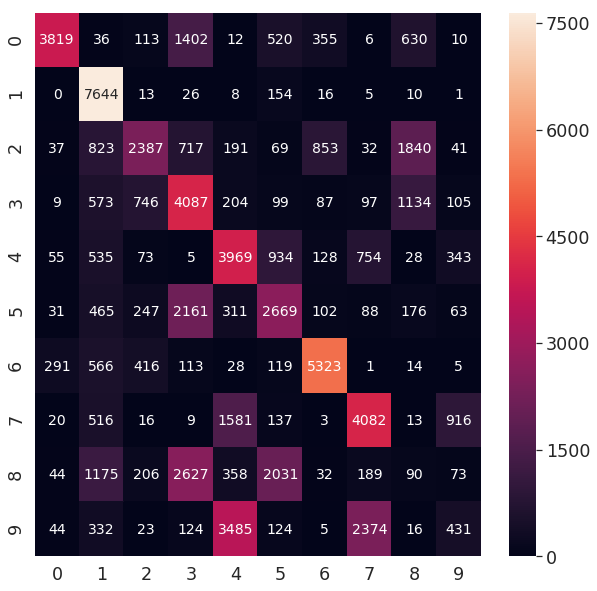

In [26]:
## PCA based eigenvectors initialzied KMeans
evaluate_clustering_assign(y, cluster_labels)


Cluster assignment using hungarian algorithm
--------------------------------------------------
Cluster label 0 assigned to true class 4
Cluster label 1 assigned to true class 1
Cluster label 2 assigned to true class 8
Cluster label 3 assigned to true class 9
Cluster label 4 assigned to true class 6
Cluster label 5 assigned to true class 2
Cluster label 6 assigned to true class 3
Cluster label 7 assigned to true class 0
Cluster label 8 assigned to true class 5
Cluster label 9 assigned to true class 7

 Classification accuracy : 0.4956714285714286

 Confusion Matrix
--------------------------------------------------
[[3491   22   64 1035   26 1392  577    8  276   12]
 [   0 7185   13   24    5    4   12    4  629    1]
 [  31  647 2760  677  175 1660  620   38  331   51]
 [   7  641  200 4322  192 1173   89   69  345  103]
 [  45  393   48    6 3990   42  151  848  817  484]
 [  36  336  115 2066  364  288  122   84 2825   77]
 [ 281  444  713   59   37   39 5117    1  179    6]
 [  16

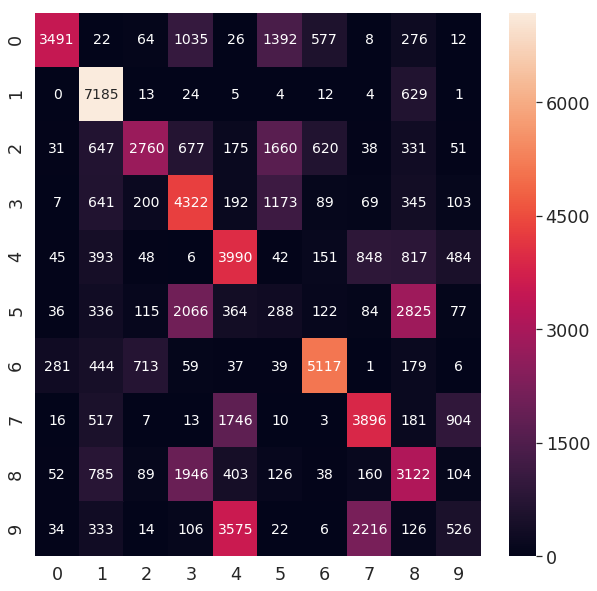

In [306]:
## Best of 10 Random initialzied KMeans
evaluate_clustering_assign(y, random_cluster_labels_dict[sorted_keys[0]])

# Spectral Clustering

In [66]:

## Spectral Clustering

class SpectralClustering:
    # d - pca dimensionality reduction parameter
    # n_neigh - # of nearest neighbors to build knn graph
    # k - number of eigenvectors to extract
    # K - number of cluster for KMeans
    def __init__(self, d, n_neigh, k, K):
        self.d = d
        self.n_neigh = n_neigh
        self.k = k
        self.K = K
        
    def fit(self, X_pca, graph_path):
        
        # create knn graph
        np.random.seed(0)
        if not os.path.exists(graph_path):
            H = neighbors.NearestNeighbors(n_neighbors=self.n_neigh, algorithm='kd_tree', 
                                           metric='euclidean', n_jobs=16).fit(X_pca).kneighbors_graph(mode='distance')
            scipy.sparse.save_npz(graph_path, H)
        else:
            H = scipy.sparse.load_npz(graph_path)
        
        # calculate E
        E = H.copy()
        sigma = np.sum(E.data)/E.getnnz()
        E.data = np.square(E.data)
        E.data = np.divide(E.data, sigma**2)
        E.data = np.exp(-0.00001*E.data)
        
        # dividing by sum of all non-zero off-diagonal entries
        val = E.sum()
        E.data = np.divide(E.data, val)
        
        # row wise normalization
#         row_sum = E.sum(axis=1)
#         val = np.repeat(row_sum, E.getnnz(axis=1))
#         val = val.tolist()
#         val = np.array(val[0])
#         E.data /= val        
        
        E.setdiag(1.0)
        E = (E + E.transpose())/2
   
        D = scipy.sparse.diags(np.squeeze(np.array(E.sum(axis=1))), format='csr')
        print (D.data)
        D.data = np.power(D.data, -0.5)
        
        iden_mat = scipy.sparse.identity(len(y), format='csr')
        L = iden_mat - ((D.dot(E)).dot(D))
        print (type(L))
    
        eigen_vals, eigen_vecs = scipy.sparse.linalg.eigs(L, k=self.k, which='SR', return_eigenvectors=True)
        print (eigen_vals[np.argsort(eigen_vals)])
        # eigen_vecs ---> V
        eigen_vecs = eigen_vecs[:, np.argsort(eigen_vals)]
        eigen_vecs = eigen_vecs[:, 1:].real
        norm_deno = np.linalg.norm(eigen_vecs, axis=1)
        U = eigen_vecs / norm_deno[:, np.newaxis]

        sklearn_Kmeans = cluster.KMeans(init='k-means++', n_clusters=self.K, n_init=10)
        sklearn_Kmeans.fit(U)
        
        return sklearn_Kmeans.cluster_centers_, sklearn_Kmeans.labels_, U

In [231]:
## using row wise normalization in Eq 17

spec_clus = SpectralClustering(d=30, n_neigh=500, k=20, K=10)
start_time = time.time()
sc_centroids, sc_labels, _ = spec_clus.fit(X_pca, '/s0/lilly/MNIST/nn_graph_seed_0_k_500.npz')
print (f"Time taken: {time.time()-start_time}")

/s0/lilly/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values
/s0/lilly/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


Time taken: 592.3638648986816


In [67]:
# scaling by sum of all non-diagonal entries in Eq 17
# also multiplying the data by 0.0001 i.e. np.exp(-0.00001*E.data)

spec_clus = SpectralClustering(d=30, n_neigh=500, k=20, K=10)
start_time = time.time()
sc_centroids, sc_labels, _ = spec_clus.fit(X_pca, '/s0/lilly/MNIST/nn_graph_seed_0_k_500.npz')
print (f"Time taken: {time.time()-start_time}")

/s0/lilly/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


[1.00001157 1.0000212  1.00001069 ... 1.00001337 1.0000092  1.00000979]
<class 'scipy.sparse.csr.csr_matrix'>
[2.13346424e-19+0.j 4.38886737e-07+0.j 5.01524288e-07+0.j
 7.32563242e-07+0.j 7.80629284e-07+0.j 8.36401454e-07+0.j
 9.43920017e-07+0.j 1.11146682e-06+0.j 1.31400010e-06+0.j
 1.51109883e-06+0.j 1.57347187e-06+0.j 1.62991490e-06+0.j
 1.67464111e-06+0.j 1.73330155e-06+0.j 1.89448278e-06+0.j
 2.10387313e-06+0.j 2.34391314e-06+0.j 2.42735585e-06+0.j
 2.44382120e-06+0.j 2.52515092e-06+0.j]
Time taken: 88.25005388259888


Cluster assignment using hungarian algorithm
--------------------------------------------------
Cluster label 0 assigned to true class 0
Cluster label 1 assigned to true class 3
Cluster label 2 assigned to true class 9
Cluster label 3 assigned to true class 2
Cluster label 4 assigned to true class 6
Cluster label 5 assigned to true class 8
Cluster label 6 assigned to true class 5
Cluster label 7 assigned to true class 7
Cluster label 8 assigned to true class 4
Cluster label 9 assigned to true class 1

 Classification accuracy : 0.7447714285714285

 Confusion Matrix
--------------------------------------------------
[[6637    5   14   26    7  105   56    4   44    5]
 [   0 7754   31   19   10   19   20    3   14    7]
 [  97   87 5350  251   18  784   36   73  261   33]
 [  22  115   81 4838   18 1490   17  112  352   96]
 [  23  107   86   25 3406  107   43   49    4 2974]
 [ 124   49   35 1681   42 3889  135   17  157  184]
 [ 268   41  184   35    6  145 6169    3   20    5]
 [  27

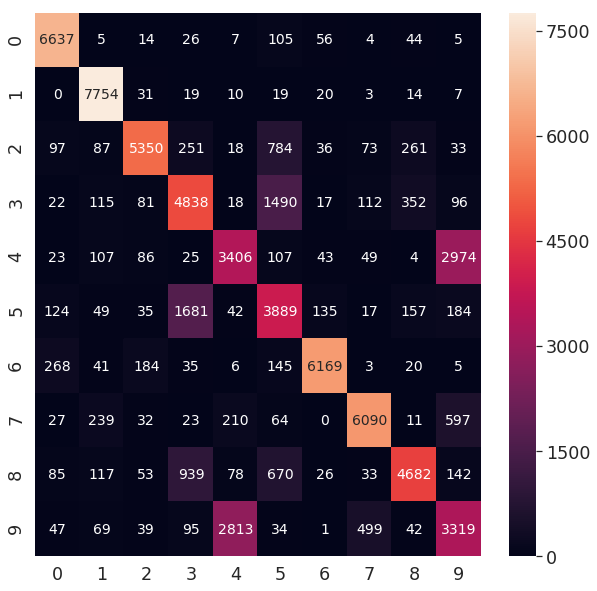

In [232]:
## using row wise normalization in Eq 17
evaluate_clustering_assign(y, sc_labels)

Cluster assignment using hungarian algorithm
--------------------------------------------------
Cluster label 0 assigned to true class 2
Cluster label 1 assigned to true class 3
Cluster label 2 assigned to true class 7
Cluster label 3 assigned to true class 5
Cluster label 4 assigned to true class 4
Cluster label 5 assigned to true class 1
Cluster label 6 assigned to true class 6
Cluster label 7 assigned to true class 0
Cluster label 8 assigned to true class 8
Cluster label 9 assigned to true class 9

 Classification accuracy : 0.6033

 Confusion Matrix
--------------------------------------------------
[[6729    3   12   32    8    1   59    1   52    6]
 [1277 3553   30   17    6 2948   19    8   12    7]
 [ 492   52 5708  283   19   32   36   63  285   20]
 [1004   25   91 5287    8  101   17   66  442  100]
 [ 617   40   56   17 3344   53   35   34    4 2624]
 [3572   14   25 1920   17   38  139   31  383  174]
 [1538   25   33   27    5   16 5203    0   23    6]
 [1800  133   30  

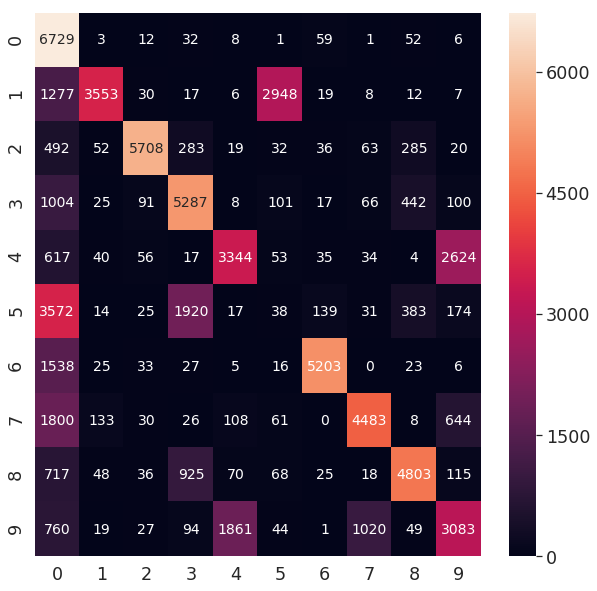

In [68]:
# scaling by sum of all non-diagonal entries in Eq 17
# also multiplying the data by 0.0001 i.e. np.exp(-0.00001*E.data)

evaluate_clustering_assign(y, sc_labels)

# kNN implementation

In [31]:
def select_Xs(X_transformed, y, cluster_centroids):
    S = []
    X_S = []
    Y_S = []
    for i in range(len(cluster_centroids)):
        dists_to_centroid = [np.linalg.norm(cluster_centroids[i]-X_transformed[j]) for j in range(len(X_transformed))]
        nearest_pt = dists_to_centroid.index(np.min(dists_to_centroid))
        S.append(nearest_pt)
        X_S.append(X_transformed[nearest_pt])
        Y_S.append(y[nearest_pt])
    X_S = np.array(X_S)
    Y_S = np.array(Y_S)
    print(f"Size of S: {len(S)}, shape of X_S: {X_S.shape}, shape of Y_S: {Y_S.shape}")
    return S, X_S, Y_S


def knn_classifier(X_transformed, y, S, X_S, Y_S, k):

    assert (X_transformed.shape[1] == X_S.shape[1])
    
    V_minus_S = list(set([i for i in range(len(X_transformed))]) - set(S))
    labels_true = []
    labels_pred = []
    
    for idx in V_minus_S:
        dists_to_X_S = [np.linalg.norm(X_transformed[idx] - X_S[j]) for j in range(len(S))]
        sorted_dist_indices = np.argsort(dists_to_X_S)[:k]
        y_labels = list(Y_S[sorted_dist_indices])
        majority_vote = max(set(y_labels), key=y_labels.count)
        
        labels_true.append(y[idx])
        labels_pred.append(majority_vote)
        
    cls_acc = accuracy_score(labels_true,labels_pred)
    print (f"Classification accuracy for {k}-NN classifier: {cls_acc}")
    
    
def select_Xs_random_sampling(X_transformed, y):
    S = []
    X_S = []
    Y_S = []
    np.random.seed(0)
    S = list(np.random.choice([i for i in range(len(y))], 100, replace=False))
    for idx in S:
        X_S.append(X_transformed[idx])
        Y_S.append(y[idx])
    X_S = np.array(X_S)
    Y_S = np.array(Y_S)
    print(f"Size of S: {len(S)}, shape of X_S: {X_S.shape}, shape of Y_S: {Y_S.shape}")
    return S, X_S, Y_S        

## KMeans + knn

In [ ]:
## KMeans + kNN

## using random data points as cluster centroids

random_centroids_100_dict, random_cluster_labels_100_dict, random_sse_100 = {}, {}, {}
seeds = [i for i in range(10)]


for i, seed in enumerate(seeds):
    kmeans = KMeans(K=100, threshold=0.0001, iters=300)
    c_centroids, c_labels, c_sse = kmeans.fit(X_pca, initialization_method='random', seed=seed)
    random_centroids_100_dict[i] = c_centroids
    random_cluster_labels_100_dict[i] = c_labels
    random_sse_100[i] = c_sse


In [16]:
## Best of 10 randomly initialzied KMeans
sorted_keys = sorted(random_sse_100.keys(), key=lambda k: random_sse_100[k])

## clustering evaluation
print_clustering_metrics(y, random_cluster_labels_100_dict[sorted_keys[0]])

Clustering Metrics
-------------------------------------
Homogeneity score: 0.7285280271763057
Completeness score: 0.37628980879289314
V measure score: 0.49625859236052083
Adjusted rand score: 0.1438396998331146
Adjusted mutual information score: 0.37539361528362475


In [33]:
# imported just to check class frequency in X_S
from collections import Counter

S, X_S, Y_S = select_Xs(X_pca, y, random_centroids_100_dict[sorted_keys[0]])
print (Counter(Y_S))

ks = [1, 3 , 5]
for k in ks:
    knn_classifier(X_pca, y, S, X_S, Y_S, k)

Size of S: 100, shape of X_S: (100, 30), shape of Y_S: (100,)
Counter({7: 14, 3: 11, 0: 11, 2: 10, 6: 10, 5: 10, 9: 10, 8: 8, 4: 8, 1: 8})
Classification accuracy for 1-NN classifier: 0.8113304721030042
Classification accuracy for 3-NN classifier: 0.7604434907010015
Classification accuracy for 5-NN classifier: 0.7254935622317596


## Spectral Clustering + kNN

In [69]:
## Spectral Clustering + kNN
## using Eq 17 as it is and scalar parameter in exponential

spec_clus = SpectralClustering(d=30, n_neigh=500, k=20, K=100)
start_time = time.time()
sc_centroids_100, sc_labels_100, U = spec_clus.fit(X_pca, '/s0/lilly/MNIST/nn_graph_seed_0_k_500.npz')
print (f"Time taken: {time.time()-start_time}")


/s0/lilly/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


[1.00001157 1.0000212  1.00001069 ... 1.00001337 1.0000092  1.00000979]
<class 'scipy.sparse.csr.csr_matrix'>
[2.09958292e-19+0.j 4.38886737e-07+0.j 5.01524288e-07+0.j
 7.32563242e-07+0.j 7.80629284e-07+0.j 8.36401454e-07+0.j
 9.43920017e-07+0.j 1.11146682e-06+0.j 1.31400010e-06+0.j
 1.51109883e-06+0.j 1.57347187e-06+0.j 1.62991490e-06+0.j
 1.67464111e-06+0.j 1.73330155e-06+0.j 1.89448278e-06+0.j
 2.10387313e-06+0.j 2.34391314e-06+0.j 2.42735585e-06+0.j
 2.44382120e-06+0.j 2.52515092e-06+0.j]
Time taken: 260.0157697200775


In [70]:
print_clustering_metrics(y, sc_labels_100)

/s0/lilly/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering Metrics
-------------------------------------
Homogeneity score: 0.766512214397353
Completeness score: 0.39020224817590166
V measure score: 0.5171454131329221
Adjusted rand score: 0.14278879353268226
Adjusted mutual information score: 0.389339624134751


In [71]:
S, X_S, Y_S = select_Xs(U, y, sc_centroids_100)

ks = [1, 3, 5]
for k in ks:
    knn_classifier(U, y, S, X_S, Y_S, k)

Size of S: 100, shape of X_S: (100, 19), shape of Y_S: (100,)
Classification accuracy for 1-NN classifier: 0.8332474964234621
Classification accuracy for 3-NN classifier: 0.8231902718168813
Classification accuracy for 5-NN classifier: 0.8092703862660944


In [72]:
print (Counter(Y_S))

Counter({8: 12, 0: 12, 2: 11, 9: 10, 1: 10, 3: 10, 6: 9, 7: 9, 4: 9, 5: 8})


## Random Sampling + kNN

In [34]:
S, X_S, Y_S = select_Xs_random_sampling(X_pca, y)
print (Counter(Y_S))
ks = [1, 3 , 5]
for k in ks:
    knn_classifier(X_pca, y, S, X_S, Y_S, k)

Size of S: 100, shape of X_S: (100, 30), shape of Y_S: (100,)
Counter({4: 18, 0: 14, 5: 14, 7: 13, 1: 10, 3: 9, 2: 6, 6: 6, 9: 5, 8: 5})
Classification accuracy for 1-NN classifier: 0.6965092989985694
Classification accuracy for 3-NN classifier: 0.6503862660944206
Classification accuracy for 5-NN classifier: 0.6024749642346209
